In [2]:
import pandas as pd
import numpy as np
import sys
import glancewriterDecoder as gd
import re
import matplotlib.pyplot as plt
sys.path.append("..") #voodoo shit
from trie.keyboard import create_keyboard
from trie.trie import Node, insert_key
from trie.predict import predict

from clustering.TCluster import TCluster

import os
import json
# %matplotlib widget
%matplotlib inline

In [3]:
def GetGazePathsFromFile(file_path):
    try:
        # Open and read the file
        gazePaths = []
        topWords = []
        with open(file_path, 'r') as file:
            content = file.readlines()
        for line in content:
            # print(line)
            if (line.strip().startswith('{')):
                corrected_content = correct_json(line)
                # print(corrected_content)
                data = json.loads(corrected_content)
                if "top_words" in data:
                    topWords.append(data["top_words"])
                if "gaze_points" in data:
                    points = data["gaze_points"]
                    points = [(point['x'], point['y'], point['z']) for point in points]
                    gazePaths.append(points)
        return gazePaths, topWords
        # for i, path in enumerate(gazePaths):
        #     print(i)
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Invalid JSON format in the file: {str(e)}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None

def correct_json(content):
    # Replace single quotes with double quotes
    content = content.replace("'", '"')
    
    # Correct boolean values
    content = content.replace('True', 'true').replace('False', 'false')
    
    # Remove trailing commas in lists and objects
    content = re.sub(r',\s*}', '}', content)
    content = re.sub(r',\s*]', ']', content)
    
    # Wrap the entire content in curly braces if it's not already
    if not content.strip().startswith('{'):
        content = '{' + content + '}'
    
    return content

In [14]:
gaze_paths, top_words = GetGazePathsFromFile("../eyeData/eyeTracking2024-10-09 14-03-55.txt")

In [15]:
# trying to decode with GlanceWriter decoder
keyboard_layout = gd.read_keyboard_layout("circleLayout.txt")
decoder = gd.GlanceWriterDecoder(keyboard_layout)

# Insert words into the trie
# words = ["move", "more", "mode", "mole"]
df_training = pd.read_csv('../data/vocab_final.csv')

training_words = df_training['word'].tolist()

# Filter only the words that are alpha
training_words = [str(word).lower() for word in training_words if str(word).isalpha()]

for word in training_words:
    decoder.insert_word(word)

# Simulate a gaze path (this should be replaced with actual gaze data)
for i in range(1):
    gaze_path = gaze_paths[i]
    gaze_path = [(point[0], point[1]) for point in gaze_path]
    print(gaze_path)
    # with open("sample_path.txt", "r") as file:
    #     for line in file:
    #         noParen = line[1:-2]
    #         nums = noParen.split(",")
    #         gaze_path.append((float(nums[0].strip()), float(nums[1].strip())))
    # gaze_path = [(85, 55), (95, 45), (130, 15), (180, 35)]

    # Decode the gaze path
    result = decoder.decode_gaze_path(gaze_path)
    print("Top 5 candidates:", result)

[(0.3636137843132019, 0.16398876905441284), (0.37651729583740234, 0.1629474014043808), (0.36147916316986084, 0.16285546123981476), (0.3678945302963257, 0.1572876125574112), (0.37445589900016785, 0.15689286589622498), (0.38627707958221436, 0.15330331027507782), (0.3887996971607208, 0.1513768434524536), (0.381816029548645, 0.16639526188373566), (0.3803630471229553, 0.1555190086364746), (0.3737349510192871, 0.15432891249656677), (0.3806765675544739, 0.149682879447937), (0.3779354691505432, 0.13352110981941223), (0.35936227440834045, 0.13749530911445618), (0.3466704487800598, 0.1647976040840149), (0.3565192222595215, 0.16824312508106232), (0.35197699069976807, 0.17193111777305603), (0.3513099253177643, 0.18205443024635315), (0.34198272228240967, 0.1767614632844925), (0.34372052550315857, 0.18344207108020782), (0.33253997564315796, 0.17915774881839752), (0.3302898406982422, 0.18439897894859314), (0.32955455780029297, 0.18203634023666382), (0.34080472588539124, 0.1761067658662796), (0.334584

In [19]:
# Offline decoding for TCluster
vocab_path = os.path.join('../', 'data', 'vocab_final.csv')
vocab = pd.read_csv(vocab_path)

# Filter only the words that are alpha
training_words = [str(word).lower() for word in training_words if str(word).isalpha()]
root = Node()
for word in training_words:
    insert_key(root, word)



with open("circleLayout.txt", "r") as f:
    text = f.read()
    corrected_text = correct_json(text)
    layout = json.loads(corrected_text)
    custom_keyboard = create_keyboard(layout["keyboard"], useString=True)
    center = (layout['center']['x'], layout['center']['y'])
    inner_radius = layout['inner_radius']
    outer_radius = layout['outer_radius']

print(center)
print(inner_radius)
print(outer_radius)
bigram_path = os.path.join('..', 'data', 'bigram_v2.json')
# truth = ["the", "leaf", "drops", "drops", "to", "the", "ground", "", "the", "night", "sky", "is",
#  "bright", "and", "and", "clear", "clear", "a", "small", "stream", "stream", "flows", "under", "the", "bridge",
#   "gentle", "waves", "lap", "at", "at", "the", "shore", "everyone", "everyone", "must", "know", "all", "the", "rules", "", "", ""]
with open(bigram_path, 'r') as f:
    bigram_probs: dict[dict] = json.load(f)

all_words = []
for i in range(len(top_words)):
    # gaze_path = gaze_paths[i]
    last_two: list[str] = ['<s>', '<s>']
    context_probs: dict[dict] = bigram_probs.get(' '.join(last_two), {})
    tc = TCluster(K=1, eps=0.07, vocab=vocab, context_probs=context_probs)

    filtered_gaze_path = gaze_paths[i]
    filtered_gaze_path = [(point[0], point[1], point[2]) for point in filtered_gaze_path if ((point[0] - center[0])**2 + (point[1] - center[1])**2 > inner_radius**2 and 
                                                                        (point[0] - center[0])**2 + (point[1] - center[1])**2 < outer_radius**2)]
    df = pd.DataFrame(filtered_gaze_path, columns=['x', 'y', 'time'])
    
    tc.fit(df)
    
    keys = tc.predict(custom_keyboard, root)
    predictions = [key[0] for key in keys]
    # print(truth[i])
    # print(str(predictions))
    all_words.append(predictions)
    # print("offline predicted words: " + str(predictions))
    # print("words predicted live: " + str(top_words[i]))


(-0.009399980306625366, -0.125)
0.3230000138282776
0.5


In [24]:
# print(all_words)
truth = ["draft", "draft", "banana", "banana", "banana", "banana", "driving", "crisis", "eleven", "garage", "knock", "knock",
 "start", "relax", "relax", "relax", "work", "stopped", "stopped", "window", "moment", "moment", "shower", "pursue", "plague",
  "plague", "plague", "shine", "shine", "shine", "shine", "security", "security", "medical", "the", "leaf", "drops", "drops",
   "drops", "drops", "to", "to", "to", "to", "the", "ground", "ground", "ground", "the", "night", "sky", "sky", "sky", "is", "is",
    "clear", "bright", "bright", "bright", "bright", "bright", "bright", "bright", "and", "clear", "a", "a", "a", "a", "small",
     "stream", "stream", "flows", "under", "under", "under", "under", "under", "under", "under", "under", "the", "bridge", "gentle",
      "waves", "waves", "lap", "lap", "lap", "at", "the", "shore", "everyone", "everyone", "must", "must", "know", "all", "all",
       "all", "all", "all", "all", "all", "the", "rules"]
# print(truth)

In [26]:
# Iterating over eps hyperparameter to see what value is the best
# scores = []
# eeps = []
# for k in range(20):
#     score = 0
#     eep = float(k+1)/100.0
#     for i in range(len(top_words)):
#         last_two: list[str] = ['<s>', '<s>']
#         context_probs: dict[dict] = bigram_probs.get(' '.join(last_two), {})
#         tc = TCluster(K=1, eps=eep, vocab=vocab, context_probs=context_probs)

#         filtered_gaze_path = gaze_paths[i]
#         filtered_gaze_path = [(point[0], point[1], point[2]) for point in filtered_gaze_path if ((point[0] - center[0])**2 + (point[1] - center[1])**2 > inner_radius**2 and 
#                                                                             (point[0] - center[0])**2 + (point[1] - center[1])**2 < outer_radius**2)]
#         df = pd.DataFrame(filtered_gaze_path, columns=['x', 'y', 'time'])
        
#         tc.fit(df)
        
#         keys = tc.predict(custom_keyboard, root)
#         predictions = [key[0] for key in keys]
#         if (truth[i] in predictions):
#             score += 1
#     scores.append(score)
#     eeps.append(eep)
#     print(score)
#     print(eep)

0
0.01
0
0.02
0
0.03
61
0.04
58
0.05
55
0.06
56
0.07
53
0.08
53
0.09
50
0.1
41
0.11
34
0.12
31
0.13
30
0.14
27
0.15
24
0.16
21
0.17
21
0.18
21
0.19
20
0.2


Text(0, 0.5, 'score')

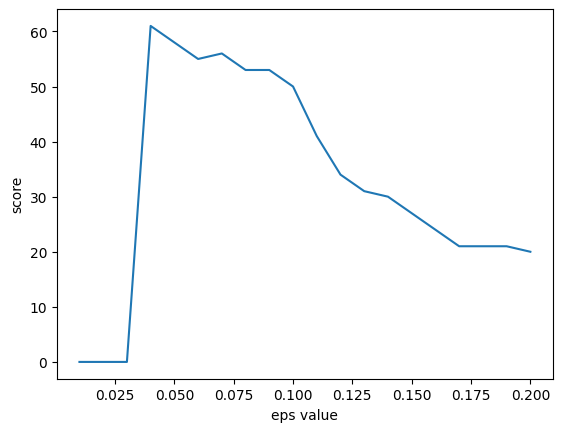

In [27]:
# plt.plot(eeps, scores)
# plt.xlabel("eps value")
# plt.ylabel("score")

In [28]:
with open("circleLayout.txt", "r") as f:
    text = f.read()
    corrected_text = correct_json(text)
    layout = json.loads(corrected_text)
    key_position = [key.split(' ') for key in layout["keyboard"].split("\n")]
    pos_strings = [info[1][1:-2].split(',') for info in key_position]
    pos = [[float(elem[0]), float(elem[1])] for elem in pos_strings]
    key_positions_df = pd.DataFrame(pos, index=[info[0] for info in key_position], columns=["x", "y"])

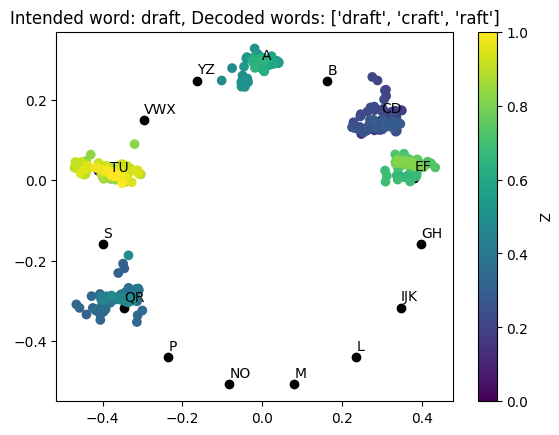

In [29]:

fig, ax = plt.subplots()
ax.scatter(key_positions_df["x"], key_positions_df["y"], c="black")
i = 1
filtered_gaze_path = gaze_paths[i]
filtered_gaze_path = [(point[0], point[1], point[2]) for point in filtered_gaze_path if ((point[0] - center[0])**2 + (point[1] - center[1])**2 > inner_radius**2 and 
                                                                        (point[0] - center[0])**2 + (point[1] - center[1])**2 < outer_radius**2)]
filtered_df = pd.DataFrame(filtered_gaze_path, columns=['x', 'y', 'time'])
ax.scatter(filtered_df["x"], filtered_df["y"], c=filtered_df["time"])
# ax.plot(filtered_df["x"], filtered_df["y"], c=filtered_df["time"])

cbar = plt.colorbar(ax.collections[0])
cbar.set_label('Z', rotation=270, labelpad=15)
ax.set_title("Intended word: " + truth[i] + ", Decoded words: " + str(top_words[i]))
for index, row in key_positions_df.iterrows():
    ax.annotate(index, row, xytext=(0,5), textcoords='offset points')
plt.show()


In [30]:
def timeseries_scatter_plot(df, ax=None, scatter_kwargs={}, line_kwargs={}, 
                            start_color='green', end_color='red'):
    """
    Create a 2D scatter plot with points connected by lines to show time series progression.
    
    Parameters:
    x, y: arrays of coordinates
    ax: matplotlib axes object. If None, a new figure and axes will be created.
    scatter_kwargs: dictionary of keyword arguments to pass to plt.scatter
    line_kwargs: dictionary of keyword arguments to pass to plt.plot
    
    Returns:
    ax: The matplotlib axes object with the plot
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create scatter plot for all points except first and last
    x = df["x"]
    y = df["y"]
    scatter = ax.scatter(x[1:-1], y[1:-1], c=df["time"][1:-1], **scatter_kwargs, cmap = "plasma")
    
    # Plot first and last points with different colors
    ax.scatter(x[0], y[0], c=start_color, s=scatter_kwargs.get('s', None) * 2 if 's' in scatter_kwargs else 100, zorder=5)
    ax.scatter(x[len(x)-1], y[len(y)-1], c=end_color, s=scatter_kwargs.get('s', None) * 2 if 's' in scatter_kwargs else 100, zorder=5)
    
    # Connect points with lines
    # lines = ax.plot(x, y, **line_kwargs)
    
    # Add arrows to show direction of time
    for i in range(len(x) - 1):
        ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                    arrowprops=dict(arrowstyle='->', color=line_kwargs.get('color', 'b'), alpha=0.5))
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Add legend
    ax.scatter([], [], c=start_color, label='Start', s=100)
    ax.scatter([], [], c=end_color, label='End', s=100)
    ax.scatter([], [], c=scatter_kwargs.get('c', 'C0'), label='Trajectory', s=scatter_kwargs.get('s', 20))
    ax.legend()
    
    return ax

C:\Users\awefel2\AppData\Local\Temp\3\ipykernel_28344\1859420171.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  square = plt.Rectangle((row[0] - width/2, row[1] - width/2), width, width, color="black", alpha=0.1)


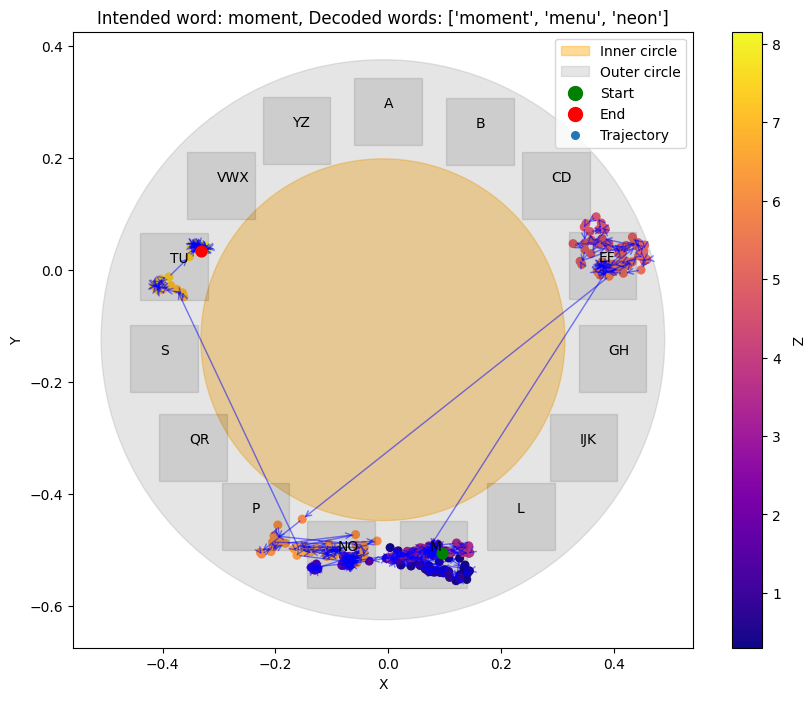

In [34]:
show_keys = True
show_key_points = False
i = 21
do_filter = True
use_image = False
use_truth = True

fig, ax = plt.subplots(figsize=(10, 8))
if (show_key_points):
    ax.scatter(key_positions_df["x"], key_positions_df["y"], c="black", zorder=19, alpha=0.4)

if (do_filter):
    filtered_gaze_path = gaze_paths[i]
    filtered_gaze_path = [(point[0], point[1], point[2]) for point in filtered_gaze_path if ((point[0] - center[0])**2 + (point[1] - center[1])**2 > inner_radius**2 and 
                                                                            (point[0] - center[0])**2 + (point[1] - center[1])**2 < outer_radius**2)]
    filtered_df = pd.DataFrame(filtered_gaze_path, columns=['x', 'y', 'time'])
else:
    gaze_path = gaze_paths[i]
    filtered_df = pd.DataFrame(gaze_path, columns=['x', 'y', 'time'])
inner_circle = plt.Circle(center, inner_radius, color="orange", alpha=0.4, label="Inner circle")
ax.add_patch(inner_circle)
outer_circle = plt.Circle(center, outer_radius, color="grey", alpha=0.2, label="Outer circle")
ax.add_patch(outer_circle)
# ax.scatter(filtered_df["x"], filtered_df["y"], c=filtered_df["time"])
timeseries_scatter_plot(filtered_df, ax=ax, 
                             scatter_kwargs={'s': 30},
                             line_kwargs={'c': 'gray', 'alpha': 0.5},
                             start_color='green', end_color='red')
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('Z', rotation=270, labelpad=15)
if (use_image):
    img = plt.imread("circleKeyboard.PNG")
    ax.imshow(img, extent=[-0.75, 0.75, -0.9, 0.64])
width = 0.12
if (use_truth):
    ax.set_title("Intended word: " + truth[i] + ", Decoded words: " + str(top_words[i]))
else:
    ax.set_title("Decoded words: " + str(top_words[i]))
if (show_keys):
    for index, row in key_positions_df.iterrows():
        ax.annotate(index, row, xytext=(-3,3), textcoords='offset points', zorder=20)
        square = plt.Rectangle((row[0] - width/2, row[1] - width/2), width, width, color="black", alpha=0.1)
        ax.add_patch(square)
plt.show()

In [13]:
plt.close()